In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from pydrake.all import (
    AddDefaultVisualization,
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    LoadModelDirectives,
    LoadModelDirectivesFromString,
    Parser,
    ProcessModelDirectives,
    RigidTransform,
    RollPitchYaw,
    Simulator,
    StartMeshcat,
    FindResourceOrThrow,
    MultibodyPlant,
    MeshcatVisualizer,
    InverseDynamicsController,
    PassThrough,
    Demultiplexer,
    StateInterpolatorWithDiscreteDerivative,
    MeshcatPoseSliders,
    ConstantVectorSource,
    JointSliders,
    Multiplexer
)
import manipulation
from manipulation.station import LoadScenario, MakeHardwareStation
from manipulation.utils import ConfigureParser, RenderDiagram

import sys

sys.path.append("../")

from src.station import CreatePandaStation

In [3]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


# Setup Franka Panda

In [36]:
# Model directive in YAML format
model_directive = """
directives:
    - add_model:
        name: panda
        file: package://drake_models/franka_description/urdf/panda_arm.urdf
        default_joint_positions:
            panda_joint1: [-1.57]
            panda_joint2: [0.1]
            panda_joint3: [0]
            panda_joint4: [-1.2]
            panda_joint5: [0]
            panda_joint6: [ 1.6]
            panda_joint7: [0]
    - add_weld:
        parent: world
        child: panda::panda_link0
    - add_model:
        name: panda_hand
        file: package://drake_models/franka_description/urdf/panda_hand.urdf
    - add_weld:
        parent: panda::panda_link8
        child: panda_hand::panda_hand
        X_PC:
            translation: [0, 0, 0]
            rotation: !Rpy { deg: [0, 0, -45] }
"""

env_directive = """
directives:
    - add_model:
        name: floor
        file: package://manipulation/floor.sdf
    - add_weld:
        parent: world
        child: floor::box
        X_PC:
            translation: [0, 0, -0.05]
    - add_model:
        name: foam_brick
        file: package://manipulation/hydro/061_foam_brick.sdf
        default_free_body_pose:
            base_link:
                translation: [0.55, 0.1, 0]
"""

In [92]:
builder = DiagramBuilder()

# add panda manipulation station
# station is a system consisting of subsytems ie. multi body plant, scene graphs, controllers ... etc
station = CreatePandaStation(model_directive, env_directive, meshcat)
builder.AddSystem(station)

plant = station.GetSubsystemByName("plant")
panda = plant.GetModelInstanceByName("panda")
panda_hand = plant.GetModelInstanceByName("panda_hand")
num_panda_positions = plant.num_positions(panda)
num_panda_hand_positions = plant.num_positions(panda_hand)

print("num_panda_positions: ", num_panda_positions)
print("num_panda_hand_positions: ", num_panda_hand_positions)


# builder.AddSystem(env_plant)

num_joints = plant.num_positions(panda)

meshcat.DeleteAddedControls()

# controller_plant = plant.Get

controller = station.GetSubsystemByName("panda_controller")
controller_plant = controller.get_multibody_plant_for_control()

print("controller_plant: ", controller_plant)
joint_sliders = builder.AddSystem(JointSliders(meshcat, controller_plant))

duplex = builder.AddSystem(Demultiplexer([num_panda_positions, num_panda_hand_positions]))
builder.Connect(joint_sliders.get_output_port(), duplex.get_input_port())
builder.Connect(duplex.get_output_port(0), station.GetInputPort("panda.position"))
builder.Connect(duplex.get_output_port(1), station.GetInputPort("panda_hand.position"))
# builder.Connect(joint_sliders.get_output_port(), station.GetInputPort("panda.position"))

diagram = builder.Build()
diagram.set_name("PandaFunzo")

context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
station_context = station.GetMyMutableContextFromRoot(context)

# get the joint positions of the panda
panda = plant.GetModelInstanceByName("panda")
panda_positions = plant.GetPositions(plant_context, model_instance=panda)
# s = plant.get_state_output_port(panda).Eval(plant_context)

# print("panda_positions: ", panda_positions)
# print(s, len(s))

# station.GetInputPort("panda.position").FixValue(station_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
# plant.get_actuation_input_port().FixValue(plant_context, np.ones(9) * 4)

# plant.SetPositions(plant_context, panda, [-1.57, 0.1, 0, -1.2, 0, 1.6, 2])
# plant.SetPositions(plant_context, panda, [0, 0, 0, 0, 0, 0, 0])
# plant.get_actuation_input_port().FixValue(plant_context, np.ones(9))


simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)

meshcat.StartRecording()
# simulator.AdvanceTo(0.5)
simulator.AdvanceTo(np.inf)

meshcat.PublishRecording()

ERROR:drake:Non-unique name "plant" for subsystem of type drake::multibody::MultibodyPlant<double>
ERROR:drake:Non-unique name "scene_graph" for subsystem of type drake::geometry::SceneGraph<double>


num_panda_positions 7
['Accept', 'AllocateContext', 'AllocateDiscreteVariables', 'AllocateImplicitTimeDerivativesResidual', 'AllocateInputAbstract', 'AllocateInputVector', 'AllocateOutput', 'AllocateTimeDerivatives', 'CalcConservativePower', 'CalcForcedDiscreteVariableUpdate', 'CalcForcedUnrestrictedUpdate', 'CalcImplicitTimeDerivativesResidual', 'CalcKineticEnergy', 'CalcNonConservativePower', 'CalcOutput', 'CalcPotentialEnergy', 'CalcTimeDerivatives', 'Clone', 'CreateDefaultContext', 'DeclareCacheEntry', 'DeclareInputPort', 'DoGetGraphvizFragment', 'EvalAbstractInput', 'EvalKineticEnergy', 'EvalPotentialEnergy', 'EvalTimeDerivatives', 'EvalUniquePeriodicDiscreteUpdate', 'EvalVectorInput', 'ExecuteForcedEvents', 'ExecuteInitializationEvents', 'FixInputPortsFrom', 'ForcedPublish', 'GetGraphvizFragment', 'GetGraphvizString', 'GetInputPort', 'GetInputPortLocators', 'GetMutableSubsystemContext', 'GetMutableSubsystemState', 'GetMyContextFromRoot', 'GetMyMutableContextFromRoot', 'GetOutputP

SystemExit: Failure at systems/framework/diagram.cc:1595 in Initialize(): condition 'NamesAreUniqueAndNonEmpty()' failed.

In [93]:
%tb

SystemExit: Failure at systems/framework/diagram.cc:1595 in Initialize(): condition 'NamesAreUniqueAndNonEmpty()' failed.

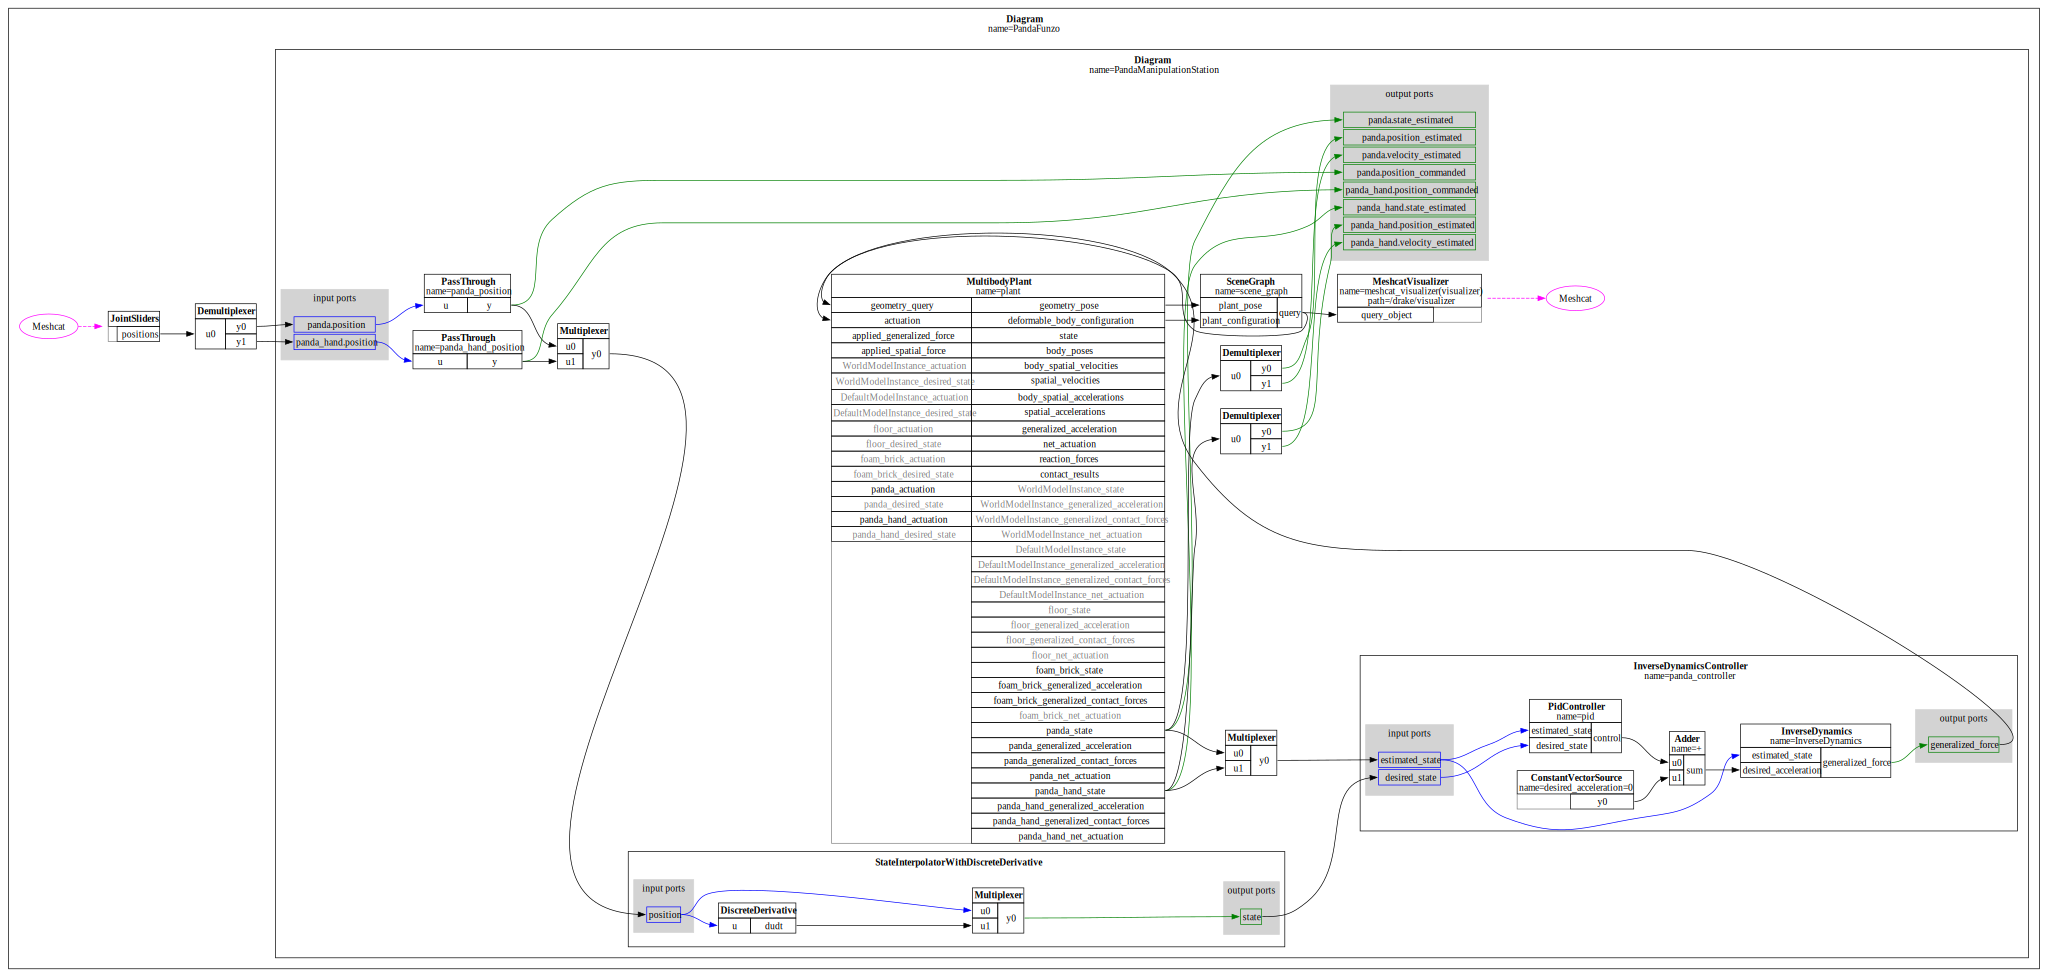

In [72]:
RenderDiagram(diagram)

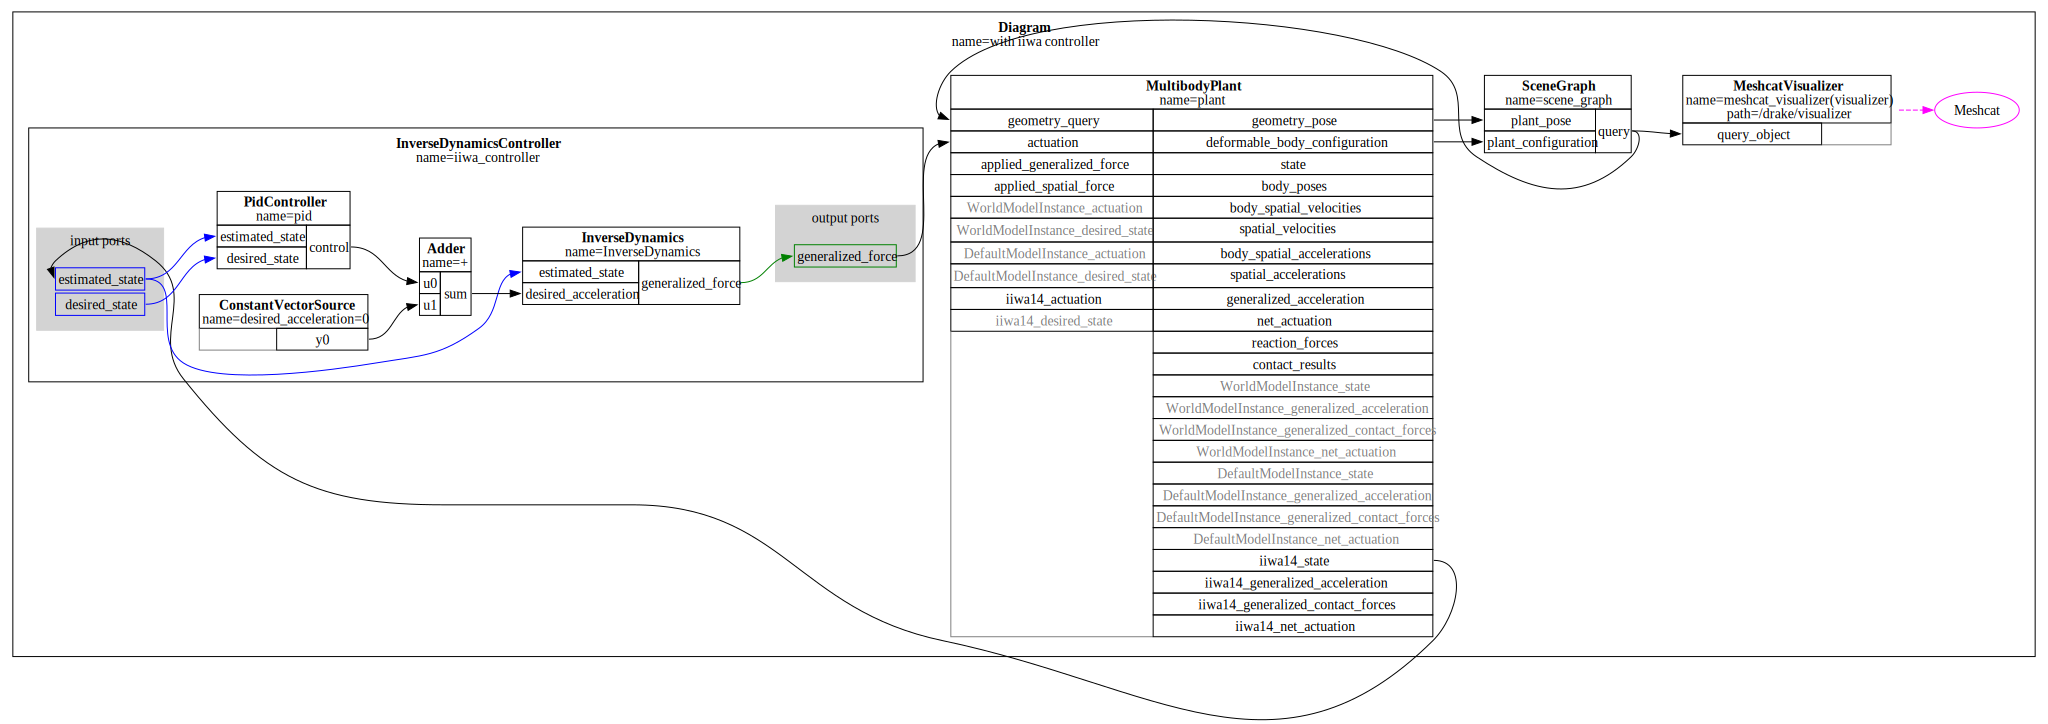

In [184]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
iiwa_model = Parser(plant, scene_graph).AddModelsFromUrl(
    "package://drake_models/iiwa_description/sdf/iiwa14_no_collision.sdf"
)[0]
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# Adds an approximation of the iiwa controller.
# TODO(russt): replace this with the joint impedance controller.
kp = [100] * plant.num_positions()
ki = [1] * plant.num_positions()
kd = [20] * plant.num_positions()
iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
iiwa_controller.set_name("iiwa_controller")
builder.Connect(
    plant.get_state_output_port(iiwa_model),
    iiwa_controller.get_input_port_estimated_state(),
)
builder.Connect(
    iiwa_controller.get_output_port_control(), plant.get_actuation_input_port()
)
diagram = builder.Build()
diagram.set_name("with iiwa controller")

RenderDiagram(diagram)